In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.executable)

/opt/miniconda3/envs/mixb/bin/python


In [41]:
def load_and_melt(file_path, value_name):
    """
    加载CSV文件并检查年份列中的无效值
    
    参数:
        file_path (str): CSV文件路径
        value_name (str): 要创建的指标名称
    
    返回:
        DataFrame: 处理后的数据框
    """
    # 读取CSV文件
    df = pd.read_csv(file_path)
    
    # 清理未命名列
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    # 转换为长格式
    melted = df.melt(
        id_vars='Countries',
        var_name='Year',
        value_name=value_name
    )
    
    # 尝试将年份转换为数值，无效值设为NaN
    melted['Year_numeric'] = pd.to_numeric(melted['Year'], errors='coerce')
    
    # 查找无效年份值
    invalid_mask = melted['Year_numeric'].isna()
    invalid_rows = melted[invalid_mask]
    
    # 如果有无效值，打印详细信息
    if not invalid_rows.empty:
        print(f"\n⚠️ 在文件 {file_path} 中发现无效年份值:")
        for idx, row in invalid_rows.iterrows():
            print(f"  行索引: {idx}, 国家: '{row['Countries']}', 无效年份值: '{row['Year']}'")
        print(f"共发现 {len(invalid_rows)} 个无效年份值\n")
    
    # 删除无效行并转换年份为整数
    melted = melted.dropna(subset=['Year_numeric'])
    melted['Year'] = melted['Year_numeric'].astype(int)
    melted = melted.drop(columns=['Year_numeric'])
    
    return melted

'''
def load_and_melt(file_path, value_name):
    """
    读取文件并转换为长格式（Country, Year, Value）
    """
    # 读取文件，第一列为国家名称
    df = pd.read_csv(file_path)   
    # 转换为长格式
    melted = df.melt(
        id_vars='Countries',
        var_name='Year',
        value_name=value_name
    )
    melted['Year'] = melted['Year'].astype(int)  # 确保年份为整数
    return melted
'''
# 示例：加载 CE 数据
ce_df = load_and_melt('Data1/processed/CO2EmissionsFromEnergy.csv', value_name='CE')
ce_df

,Countries,Year,CE
0,Canada,1965,260.3
1,Mexico,1965,62.1
2,US,1965,3451.9
3,Argentina,1965,82.2
4,Brazil,1965,51.5
...,...,...,...
5331,Sri Lanka,2022,19.9
5332,Taiwan,2022,272.4
5333,Thailand,2022,275.3
5334,Vietnam,2022,270


In [42]:
# 定义文件路径及其对应的指标名
file_config = {
    #'Data1/processed/EmissionsFromCementProduction.csv': 'Cement_CE',
    'Data1/processed/CarbonSequestration.csv': 'cement_CS',
    'Data1/processed/PrimaryEnergyConsumption.csv': 'energy_consumption',
    'Data1/processed/Population.csv': 'Population',
    'Data1/processed/GDP.csv': 'GDP',
    'Data1/processed/CementProduction.csv': 'cement_production',
    'Data1/processed/CementConsumption.csv': 'cement_consumption(volume)'
}

In [43]:
# 初始化合并后的 DataFrame
merged_df = None

# 逐个加载并合并
for file, col_name in file_config.items():
    print(f"处理文件: {file}")
    temp_df = load_and_melt(file, col_name)  # 使用修改后的函数
    
    if merged_df is None:
        merged_df = temp_df
        print(f"  初始数据框大小: {merged_df.shape}")
    else:
        before_merge = merged_df.shape[0]
        merged_df = pd.merge(
            merged_df,
            temp_df, 
            on=['Countries', 'Year'],  # 注意列名是'Countries'而不是'Country'
            how='inner'
        )
        after_merge = merged_df.shape[0]
        print(f"  合并后数据框大小: {merged_df.shape}, 减少行数: {before_merge - after_merge}")

# 按国家和年份排序
merged_df = merged_df.sort_values(['Countries', 'Year']).reset_index(drop=True)
print("\n✅ 所有文件处理完成!")
print(f"最终数据框大小: {merged_df.shape}")

# --- 新增: 筛选1975年之后的数据 ---
merged_df = merged_df[merged_df['Year'] >= 1975]
print(f"筛选1975年之后的数据: {merged_df.shape}")

# 将所有数值列转换为浮点数（为后续除法计算）
numeric_cols = [
    'cement_CS', 'energy_consumption', 'Population', 
    'GDP', 'cement_production', 'cement_consumption(volume)'
]

for col in numeric_cols:
    # 转换并记录无效值数量
    initial_count = len(merged_df)
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    
    invalid_count = merged_df[col].isna().sum()
    if col == 'cement_CS':
        print("skip CS")
        continue
    if invalid_count > 0:
        print(f"⚠️ 列 '{col}' 中发现 {invalid_count} 个无效值，已替换为NaN")
        
# 删除包含NaN的行
before_clean = len(merged_df)
merged_df = merged_df.dropna(subset=numeric_cols)
after_clean = len(merged_df)
print(f"🧹 清理无效值: 删除 {before_clean - after_clean} 行，剩余 {after_clean} 行")

merged_df



处理文件: Data1/processed/CarbonSequestration.csv
  初始数据框大小: (16856, 3)
处理文件: Data1/processed/PrimaryEnergyConsumption.csv
  合并后数据框大小: (4350, 4), 减少行数: 12506
处理文件: Data1/processed/Population.csv
  合并后数据框大小: (3886, 5), 减少行数: 464
处理文件: Data1/processed/GDP.csv
  合并后数据框大小: (3886, 6), 减少行数: 0
处理文件: Data1/processed/CementProduction.csv
  合并后数据框大小: (3886, 7), 减少行数: 0
处理文件: Data1/processed/CementConsumption.csv
  合并后数据框大小: (2211, 8), 减少行数: 1675

✅ 所有文件处理完成!
最终数据框大小: (2211, 8)
筛选1975年之后的数据: (2211, 8)
skip CS
⚠️ 列 'GDP' 中发现 10 个无效值，已替换为NaN
🧹 清理无效值: 删除 10 行，剩余 2201 行


,Countries,Year,cement_CS,energy_consumption,Population,GDP,cement_production,cement_consumption(volume)
0,Algeria,1990,0.946670,1.13,25518074.0,6.204851e+10,6503.19,6.503190
1,Algeria,1991,0.940069,1.12,26133905.0,4.571568e+10,6319.00,6.319000
2,Algeria,1992,1.075461,1.15,26748303.0,4.800313e+10,6400.00,7.983312
3,Algeria,1993,1.097931,1.07,27354327.0,4.994558e+10,6400.00,7.826559
4,Algeria,1994,1.141155,1.09,27937006.0,4.254318e+10,6060.00,8.234887
...,...,...,...,...,...,...,...,...
2206,Uzbekistan,2018,2.233903,1.92,32956100.0,5.287011e+10,9200.00,12.681282
2207,Uzbekistan,2019,2.493189,1.92,33580350.0,6.028350e+10,10990.00,14.112931
2208,Uzbekistan,2020,2.682688,1.91,34232050.0,6.022470e+10,12540.00,14.884735
2209,Uzbekistan,2021,2.804464,2.03,34915100.0,6.960061e+10,15000.00,14.859030


In [44]:
merged_df

,Countries,Year,cement_CS,energy_consumption,Population,GDP,cement_production,cement_consumption(volume)
0,Algeria,1990,0.946670,1.13,25518074.0,6.204851e+10,6503.19,6.503190
1,Algeria,1991,0.940069,1.12,26133905.0,4.571568e+10,6319.00,6.319000
2,Algeria,1992,1.075461,1.15,26748303.0,4.800313e+10,6400.00,7.983312
3,Algeria,1993,1.097931,1.07,27354327.0,4.994558e+10,6400.00,7.826559
4,Algeria,1994,1.141155,1.09,27937006.0,4.254318e+10,6060.00,8.234887
...,...,...,...,...,...,...,...,...
2206,Uzbekistan,2018,2.233903,1.92,32956100.0,5.287011e+10,9200.00,12.681282
2207,Uzbekistan,2019,2.493189,1.92,33580350.0,6.028350e+10,10990.00,14.112931
2208,Uzbekistan,2020,2.682688,1.91,34232050.0,6.022470e+10,12540.00,14.884735
2209,Uzbekistan,2021,2.804464,2.03,34915100.0,6.960061e+10,15000.00,14.859030


In [45]:
# 数据整理
# 定义分解所需的因子列名
factors = [
    'cement_CS/cement_consumption(volume)',
    'cement_consumption(volume)/cement_production',
    'cement_production/GDP',
    'GDP/Population',
    'Population/energy_consumption',
    'energy_consumption'
]

# 在计算分解因子前添加单位转换
print("执行单位转换...")
# 质量单位转换 (水泥产量: kt → Mt) 百万吨
merged_df['cement_production'] = merged_df['cement_production'] / 1000
# 经济单位转换 (GDP: USD → trillion USD) 万亿美元
merged_df['GDP'] = merged_df['GDP'] / 1e12
# 人口单位转换 (persons → billion persons) 人口(亿人)
merged_df['Population'] = merged_df['Population'] / 1e8
# 现在计算分解因子（使用统一单位）
print("计算分解因子...")

# 计算各分解因子
merged_df['cement_CS/cement_consumption(volume)'] = merged_df['cement_CS'] / merged_df['cement_consumption(volume)']
merged_df['cement_consumption(volume)/cement_production'] = merged_df['cement_consumption(volume)'] / merged_df['cement_production']
merged_df['cement_production/GDP'] = merged_df['cement_production'] / merged_df['GDP']
merged_df['GDP/Population'] = merged_df['GDP'] / merged_df['Population']
merged_df['Population/energy_consumption'] = merged_df['Population'] / merged_df['energy_consumption']
merged_df['energy_consumption'] = merged_df['energy_consumption']

# 确保所有关键列均为正数（避免对非正值取对数）
merged_df = merged_df[
    # (merged_df['cement_CS'] > 0) &
    (merged_df['cement_consumption(volume)'] > 0) &
    (merged_df['cement_production'] > 0) &
    (merged_df['GDP'] > 0) &
    (merged_df['Population'] > 0)&
    (merged_df['energy_consumption'] > 0) 
]

# 再次检查无穷大和缺失值
print("清理无穷值和缺失值...")
merged_df = merged_df.replace([np.inf, -np.inf], np.nan)
merged_df = merged_df.dropna(subset=factors + ['cement_CS'])
print(f"🧮 最终有效数据量: {len(merged_df)} 行 (1975年之后)")
print(f"🗺️ 最终有效国家列表: {merged_df["Countries"].unique()}, 共计{len(merged_df["Countries"].unique())}个")
merged_df[merged_df["Countries"] == "China"]

执行单位转换...
计算分解因子...
清理无穷值和缺失值...
🧮 最终有效数据量: 2137 行 (1975年之后)
🗺️ 最终有效国家列表: ['Algeria' 'Argentina' 'Australia' 'Austria' 'Azerbaijan' 'Bangladesh'
 'Belarus' 'Belgium' 'Brazil' 'Bulgaria' 'Canada' 'Chile' 'China'
 'Colombia' 'Croatia' 'Cyprus' 'Czechia' 'Denmark' 'Ecuador' 'Egypt'
 'Estonia' 'Finland' 'France' 'Germany' 'Greece' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Kazakhstan' 'Kuwait' 'Lithuania' 'Luxembourg' 'Malaysia' 'Mexico'
 'Morocco' 'New Zealand' 'North Macedonia' 'Norway' 'Oman' 'Pakistan'
 'Peru' 'Philippines' 'Poland' 'Portugal' 'Qatar' 'Romania' 'Saudi Arabia'
 'Slovakia' 'Slovenia' 'South Africa' 'Spain' 'Sri Lanka' 'Sweden'
 'Switzerland' 'Thailand' 'Ukraine' 'Uzbekistan'], 共计63个


,Countries,Year,cement_CS,energy_consumption,Population,GDP,cement_production,cement_consumption(volume),cement_CS/cement_consumption(volume),cement_consumption(volume)/cement_production,cement_production/GDP,GDP/Population,Population/energy_consumption
429,China,1990,28.138505,28.58,11.35185,0.360858,203.1680,203.168000,0.138499,1.000000,563.013706,0.031788,0.397196
430,China,1990,28.138505,28.58,11.35185,0.360858,203.1680,203.168000,0.138499,1.000000,563.013706,0.031788,0.397196
431,China,1991,33.244128,30.02,11.50780,0.383373,252.6100,252.610000,0.131603,1.000000,658.914425,0.033314,0.383338
432,China,1991,33.244128,30.02,11.50780,0.383373,252.6100,252.610000,0.131603,1.000000,658.914425,0.033314,0.383338
433,China,1992,39.047044,31.59,11.64970,0.426916,308.2200,302.210526,0.129205,0.980503,721.968725,0.036646,0.368778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,China,2020,359.195176,149.45,14.11100,14.687700,2394.7083,2391.579786,0.150192,0.998694,163.041749,1.040869,0.094420
491,China,2021,364.452859,157.94,14.12360,17.820500,2378.1080,2375.940938,0.153393,0.999089,133.447883,1.261753,0.089424
492,China,2021,364.452859,157.94,14.12360,17.820500,2378.1080,2375.940938,0.153393,0.999089,133.447883,1.261753,0.089424
493,China,2022,345.265282,159.39,14.12175,17.881800,2118.0000,2116.039227,0.163166,0.999074,118.444452,1.266259,0.088599


In [46]:
first_group_df = merged_df.groupby('Countries').get_group("Algeria")
first_group_df.head()

,Countries,Year,cement_CS,energy_consumption,Population,GDP,cement_production,cement_consumption(volume),cement_CS/cement_consumption(volume),cement_consumption(volume)/cement_production,cement_production/GDP,GDP/Population,Population/energy_consumption
0,Algeria,1990,0.946670,1.13,0.255181,0.062049,6.50319,6.503190,0.145570,1.000000,104.808162,0.243155,0.225824
1,Algeria,1991,0.940069,1.12,0.261339,0.045716,6.31900,6.319000,0.148769,1.000000,138.223920,0.174929,0.233338
2,Algeria,1992,1.075461,1.15,0.267483,0.048003,6.40000,7.983312,0.134714,1.247393,133.324630,0.179462,0.232594
3,Algeria,1993,1.097931,1.07,0.273543,0.049946,6.40000,7.826559,0.140283,1.222900,128.139456,0.182588,0.255648
4,Algeria,1994,1.141155,1.09,0.279370,0.042543,6.06000,8.234887,0.138576,1.358892,142.443523,0.152283,0.256303


In [51]:
results = []

for idx in range(1, len(first_group_df)):
    t_row = first_group_df.iloc[idx]
    b_row = first_group_df.iloc[idx-1]

    cfp_t = t_row["cement_CS"]
    cfp_b = b_row["cement_CS"]
    # print(cfp_t, cfp_b)
    
    # 添加对 CFP 值的保护
    if cfp_t <= 0 or cfp_b <= 0:
        continue  # 跳过非正值
    
    # 计算 L(CFP^t, CFP^b)
    if np.isclose(cfp_t, cfp_b, rtol=1e-6):  # 浮点数精度容错
        L = cfp_t
    else:
        log_diff = np.log(cfp_t) - np.log(cfp_b)
        if np.isclose(log_diff, 0):  # 防止除以零
            L = cfp_t
        else:
            L = (cfp_t - cfp_b) / log_diff
    print(L)

    # 计算各因子贡献（添加对 ratio_t/ratio_b 的保护）
    contributions = {}
    for factor in factors:
        ratio_t = t_row[factor]
        ratio_b = b_row[factor]
        if ratio_t <= 0 or ratio_b <= 0:
            contributions[f'Δ{factor}'] = np.nan
        else:
            contributions[f'Δ{factor}'] = L * np.log(ratio_t / ratio_b)
        print(f'factor: {factor}', f'value: {contributions[f"Δ{factor}"]}')

    # 跳过存在 NaN 的行
    if not np.isnan(list(contributions.values())).any():
        results.append({
            'Countries': first_group_df["Countries"],
            'Year': t_row['Year'],
            'ΔTotal': cfp_t - cfp_b,
            **contributions
        })

0.9433657248819606
factor: cement_CS/cement_consumption(volume) value: 0.020503195005235987
factor: cement_consumption(volume)/cement_production value: 0.0
factor: cement_production/GDP value: 0.2610701745517998
factor: GDP/Population value: -0.310670821767281
factor: Population/energy_consumption value: 0.03088152553395308
factor: energy_consumption value: -0.00838552832370773
1.006247201154112
factor: cement_CS/cement_consumption(volume) value: -0.09986097344798466
factor: cement_consumption(volume)/cement_production value: 0.22243637013155032
factor: cement_production/GDP value: -0.03631344509839575
factor: GDP/Population value: 0.02574735033331009
factor: Population/energy_consumption value: -0.0032157028606984417
factor: energy_consumption value: 0.02659839094221855
1.0866573971111768
factor: cement_CS/cement_consumption(volume) value: 0.044019488783677015
factor: cement_consumption(volume)/cement_production value: -0.021548925783677224
factor: cement_production/GDP value: -0.0431

In [10]:
def lmdi_decomposition(df, base_year, target_ratio='cement_CS/total_CE'):
    
    """
    执行 LMDI 分解，计算各因子贡献
    - df: 合并后的数据（包含 Country, Year 和各因子）
    - base_year: 基期年份（如 1990）
    - target_ratio: 分解的目标比例（默认为 CS/CE）
    """
    
    # 计算目标比例 CSO = CS/CE
    # df[target_ratio] = df['cement_CS'] / df['total_CE']
    # 计算目标值
    df[target_ratio] = df['cement_CS'] 
    

    # 初始化结果存储
    results = []
    for country, country_df in df.groupby('Countries'):
        country_df = country_df.sort_values('Year')
        country_df = country_df[country_df['Year'] >= base_year]
        if len(country_df) < 2:
            continue

        for idx in range(1, len(country_df)):
            t_row = country_df.iloc[idx]
            b_row = country_df.iloc[idx-1]

            cfp_t = t_row[target_ratio]
            cfp_b = b_row[target_ratio]

            # 添加对 CFP 值的保护
            if cfp_t <= 0 or cfp_b <= 0:
                continue  # 跳过非正值

            # 计算 L(CFP^t, CFP^b)
            if np.isclose(cfp_t, cfp_b, rtol=1e-6):  # 浮点数精度容错
                L = cfp_t
            else:
                log_diff = np.log(cfp_t) - np.log(cfp_b)
                if np.isclose(log_diff, 0):  # 防止除以零
                    L = cfp_t
                else:
                    L = (cfp_t - cfp_b) / log_diff

            # 计算各因子贡献（添加对 ratio_t/ratio_b 的保护）
            contributions = {}
            for factor in factors:
                ratio_t = t_row[factor]
                ratio_b = b_row[factor]
                if ratio_t <= 0 or ratio_b <= 0:
                    contributions[f'Δ{factor}'] = np.nan
                else:
                    contributions[f'Δ{factor}'] = L * np.log(ratio_t / ratio_b)
            
            # 跳过存在 NaN 的行
            if not np.isnan(list(contributions.values())).any():
                results.append({
                    'Countries': country,
                    'Year': t_row['Year'],
                    'ΔTotal': cfp_t - cfp_b,
                    **contributions
                })
    
    return pd.DataFrame(results)

In [11]:
# 设置基期年份（根据数据实际起始时间调整）
base_year = 1975  # 示例

# 运行分解
lmdi_results = lmdi_decomposition(merged_df, base_year)

# 保存结果
lmdi_results.to_csv('Data1/results/LMDI_Contributions.csv', index=False, encoding='utf-8-sig')

# 查看示例输出
print(lmdi_results.head())

/var/folders/zf/glvf6d391qg0793020jyvctc0000gn/T/ipykernel_3025/244280604.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_ratio] = df['cement_CS']


  Countries  Year    ΔTotal  Δcement_CS/cement_consumption(volume)  \
0   Algeria  1991 -0.006601                               0.020503   
1   Algeria  1992  0.135392                              -0.099861   
2   Algeria  1993  0.022471                               0.044019   
3   Algeria  1994  0.043223                              -0.013706   
4   Algeria  1995  0.021821                               0.022936   

   Δcement_consumption(volume)/cement_production  Δcement_production/GDP  \
0                                       0.000000                0.261070   
1                                       0.222436               -0.036313   
2                                      -0.021549               -0.043105   
3                                       0.118036                0.118463   
4                                      -0.027427                0.047599   

   ΔGDP/Population  ΔPopulation/energy_consumption  Δenergy_consumption  
0        -0.310671                        0.0308

In [9]:
# 验证：
lmdi_results['ΔSum'] = lmdi_results[[f'Δ{factor}' for factor in factors]].sum(axis=1)
print(lmdi_results[['ΔTotal', 'ΔSum']].head())

KeyError: "None of [Index(['Δcement_CS/cement_consumption(volume)',\n       'Δcement_consumption(volume)/cement_production',\n       'Δcement_production/GDP', 'ΔGDP/Population',\n       'ΔPopulation/energy_consumption', 'Δenergy_consumption'],\n      dtype='object')] are in the [columns]"

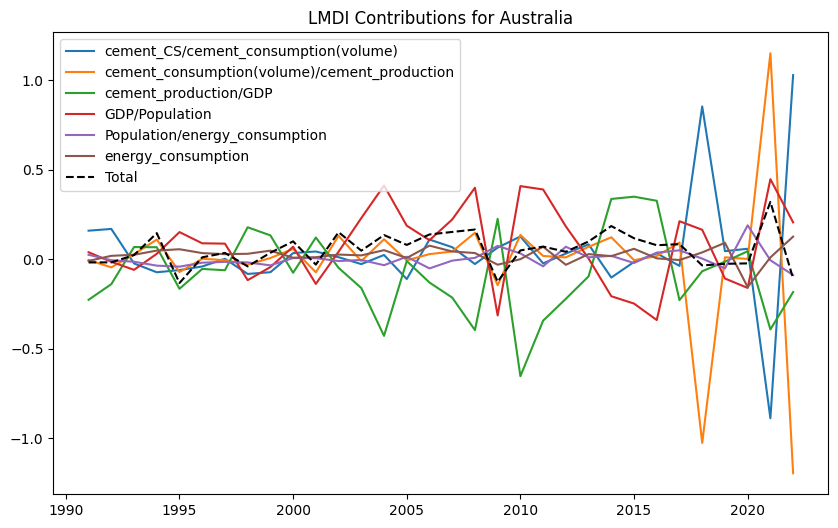

In [12]:
country = 'Australia'
df_country = lmdi_results[lmdi_results['Countries'] == country]

plt.figure(figsize=(10, 6))
for factor in factors:
    plt.plot(df_country['Year'], df_country[f'Δ{factor}'], label=factor)
plt.plot(df_country['Year'], df_country['ΔTotal'], 'k--', label='Total')
plt.title(f'LMDI Contributions for {country}')
plt.legend()
plt.show()

## 分解20年

In [13]:
def lmdi_decomposition_single_period(df, base_year, target_ratio='cement_CS/total_CE'):
    """
    执行LMDI分解（每个国家只计算最新一年与最开始一年的对比）
    - df: 合并后的数据（包含Country, Year和各因子）
    - base_year: 基期年份（如1975）
    - target_ratio: 分解的目标比例（默认为CS/CE）
    """
    # 计算目标值
    df[target_ratio] = df['cement_CS']
    
    # 初始化结果存储
    results = []
    for country, country_df in df.groupby('Countries'):
        # 筛选基期之后的数据并按年份排序
        country_df = country_df[country_df['Year'] >= base_year].sort_values('Year')
        # if len(country_df) < 2:
        #    continue  # 至少需要首尾两年数据
        
        # 获取首尾两年数据
        first_row = country_df.iloc[0]    # 最开始一年（>= base_year的最早年份）
        last_row = country_df.iloc[-1]    # 最新一年
        
        cfp_first = first_row[target_ratio]
        cfp_last = last_row[target_ratio]

        # 跳过非正值
        # if cfp_first <= 0 or cfp_last <= 0:
        #    continue

        # 计算L(CFP_last, CFP_first)
        if np.isclose(cfp_last, cfp_first, rtol=1e-6):
            L = cfp_last
        else:
            log_diff = np.log(cfp_last) - np.log(cfp_first)
            L = (cfp_last - cfp_first) / log_diff if not np.isclose(log_diff, 0) else cfp_last

        # 计算各因子贡献
        contributions = {}
        for factor in factors:
            ratio_first = first_row[factor]
            ratio_last = last_row[factor]
            if ratio_first <= 0 or ratio_last <= 0:
                contributions[f'Δ{factor}'] = np.nan
            else:
                contributions[f'Δ{factor}'] = L * np.log(ratio_last / ratio_first)
        
        # 保存结果（每个国家一条记录）
        if not np.isnan(list(contributions.values())).any():
            results.append({
                'Countries': country,
                'Start_Year': first_row['Year'],
                'End_Year': last_row['Year'],
                'ΔTotal': cfp_last - cfp_first,  # 总变化量
                **contributions
            })
    
    return pd.DataFrame(results)

In [14]:
# 运行分解（每个国家输出首尾年对比）
lmdi_results = lmdi_decomposition_single_period(merged_df, base_year=1975)

# 保存结果
lmdi_results.to_csv('Data1/results/LMDI_Contributions_FirstLast.csv', index=False)

# 查看示例输出
print(lmdi_results.head())

    Countries  Start_Year  End_Year    ΔTotal  \
0     Algeria        1990      2022  3.041146   
1   Argentina        1990      2022  1.248540   
2   Australia        1990      2022  1.705392   
3     Austria        1990      2022  0.883310   
4  Azerbaijan        1990      2022  0.310906   

   Δcement_CS/cement_consumption(volume)  \
0                              -0.046236   
1                               0.011119   
2                               1.035409   
3                               0.380751   
4                              -0.015521   

   Δcement_consumption(volume)/cement_production  Δcement_production/GDP  \
0                                       0.000000                0.357908   
1                                       0.000002               -1.442767   
2                                       0.003583               -2.585042   
3                                       0.240521               -1.389410   
4                                      -0.074613            